## Instala as coisas necessárias para correr no Google Colab

In [1]:
!lsb_release -a

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.3 LTS
Release:	18.04
Codename:	bionic


In [2]:
adicionado = False

with open('/etc/apt/sources.list') as f:
    if 'https://qgis.org/ubuntu' in f.read():
        print("Repositório já estava adicionado")
        adicionado = True

if adicionado == False:
    # Adiciona Repositório
    !echo "deb     https://qgis.org/ubuntu bionic main" >> /etc/apt/sources.list
    !echo "deb-src https://qgis.org/ubuntu bionic main" >> /etc/apt/sources.list

    # Adiciona chave pública ao apt keyring
    !wget -O - https://qgis.org/downloads/qgis-2019.gpg.key | apt-key add
    
    print("Repositório do qgis adicionado com sucesso!")

Repositório já estava adicionado


In [0]:
# Instala qgis
!apt update
!apt install qgis qgis-plugin-grass

# qgis-plugin-grass não deve ser preciso instalar mas pronto

In [0]:
!apt-cache policy qgis

In [0]:
# A versão do IPython que o google collab tem é antiga
# e não estava a dar para imprimir o mapa

# É necessário reiniciar o runtime depois de atualizar IPython
!pip install IPython --upgrade

# **Trabalho Cartografia: COVID-19**

## Introdução

Com a elaboração deste trabalho, pretende-se não só analisar os dados relativos ao COVID-19 em Portugal e no mundo, como também de alguma forma os relacionar com o turismo em Portugal.


![alt text](https://github.com/marianallc/TAprojectCOVID19/raw/master/mapaMundo.gif "mapaMundo")

## COVID-19 no Mundo geográficamente

### Preparação dos dados

In [6]:
#carrega os imports para comunicar o qsis

import os
import sys
from osgeo import ogr
os.environ['QT_QPA_PLATFORM'] = 'offscreen'
sys.path.insert(0,'/usr/share/qgis/python')
from qgis.core import *
QgsApplication.setPrefixPath("/usr/", True) 
from qgis.gui import *
from qgis import processing

from qgis.PyQt.QtGui import QColor, QImage
from qgis.PyQt.QtCore import QSize, QBuffer, QIODevice

qgs = QgsApplication([], False)
qgs.initQgis()
print(QgsApplication.showSettings())

Application state:
QGIS_PREFIX_PATH env var:		
Prefix:		/usr/
Plugin Path:		/usr//lib/qgis/plugins
Package Data Path:	/usr//share/qgis
Active Theme Name:	
Active Theme Path:	/usr//share/qgis/resources/themes//icons/
Default Theme Path:	:/images/themes/default/
SVG Search Paths:	/usr//share/qgis/svg/
		/root/.local/share/profiles/default/svg/
User DB Path:	/usr//share/qgis/resources/qgis.db
Auth DB Path:	/root/.local/share/profiles/default/qgis-auth.db



In [7]:
import urllib.request 

urllib.request.urlretrieve ("https://github.com/marianallc/TAprojectCOVID19/raw/master/mapaMundo.gpkg", "mapaMundo.gpkg")

covid_gpkg = "mapaMundo.gpkg"
conn = ogr.Open(covid_gpkg)
for i in conn:
    vlayer = QgsVectorLayer("{}|layername={}".format(covid_gpkg, i.GetName()), i.GetName(), "ogr")
    if not vlayer.isValid():
        print("Layer {} failed to load".format(i.GetName()))
    else:
        QgsProject.instance().addMapLayer(vlayer)
        print("Layer {} loaded".format(i.GetName()))

Layer 10Mar loaded
Layer 1Fev loaded
Layer 29Fev loaded
Layer 30Abr loaded
Layer layer_styles loaded


In [0]:
def gereMapaMundo(layer):
    xt = layer.extent()
    width  = 1000
    height = 500
    #print("Gerar mapa com {} por {}".format(width, height))

    options = QgsMapSettings()
    options.setLayers([layer])
    options.setBackgroundColor(QColor(255, 255, 255))
    options.setOutputSize(QSize(width, height))
    options.setExtent(xt)
              
    render = QgsMapRendererParallelJob(options)
    render.start()
    render.waitForFinished()

    image = render.renderedImage()
    return image

### Casos confirmados no mundo: 1 de Fevereiro de 2020

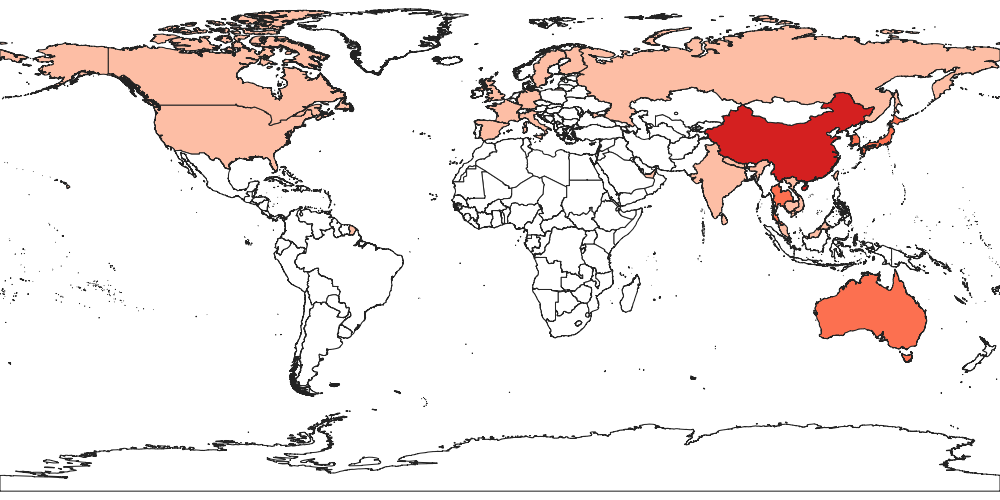

In [9]:
from IPython.display import Image

InicioFev = QgsProject.instance().mapLayersByName('1Fev')[0]
image = gereMapaMundo(InicioFev)

imgbuf= QBuffer()
imgbuf.open( QIODevice.ReadWrite )
image.save( imgbuf,"PNG" )
Image( imgbuf.data() )

### Casos confirmados no mundo: 29 de Fevereiro de 2020

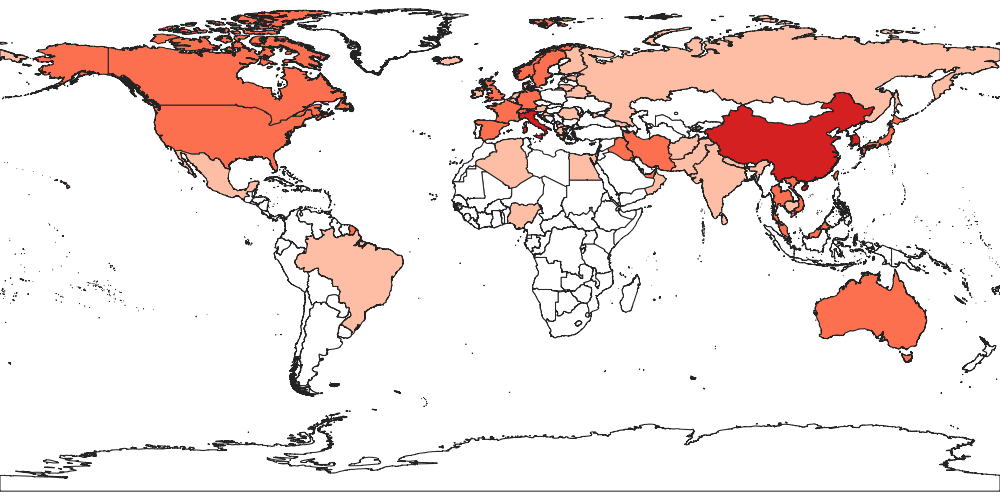

In [10]:
from IPython.display import Image

FimFev = QgsProject.instance().mapLayersByName('29Fev')[0]
image = gereMapaMundo(FimFev)

imgbuf= QBuffer()
imgbuf.open( QIODevice.ReadWrite )
image.save( imgbuf,"PNG" )
Image( imgbuf.data() )

### Casos confirmados no mundo: 10 de Março de 2020

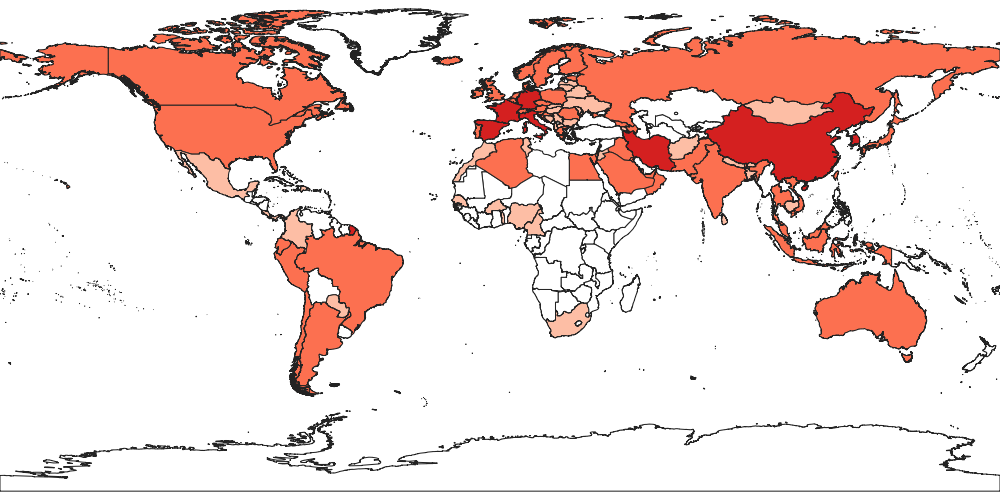

In [11]:
from IPython.display import Image

InicioMar = QgsProject.instance().mapLayersByName('10Mar')[0]
image = gereMapaMundo(InicioMar)

imgbuf= QBuffer()
imgbuf.open( QIODevice.ReadWrite )
image.save( imgbuf,"PNG" )
Image( imgbuf.data() )

### Casos confirmados no mundo: 30 de Abril de 2020

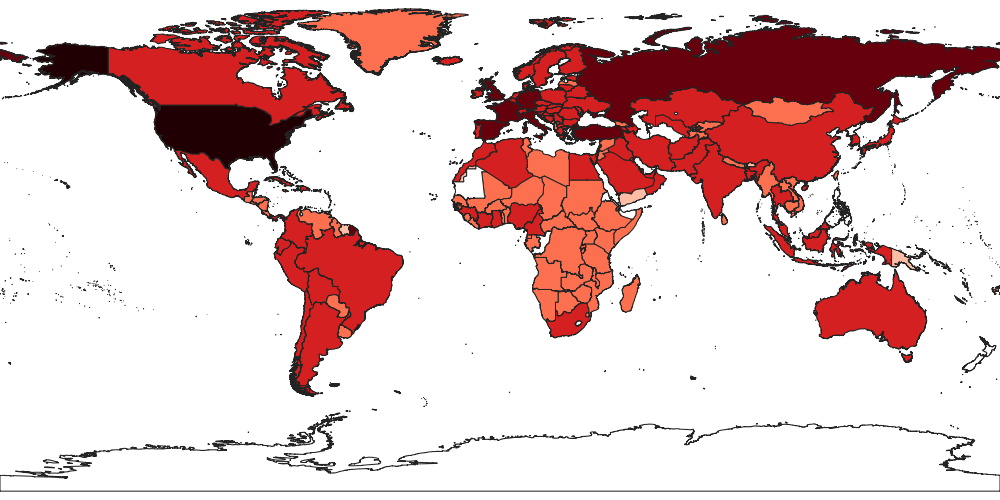

In [12]:
from IPython.display import Image

Atual = QgsProject.instance().mapLayersByName('30Abr')[0]
image = gereMapaMundo(Atual)

imgbuf= QBuffer()
imgbuf.open( QIODevice.ReadWrite )
image.save( imgbuf,"PNG" )
Image( imgbuf.data() )

## Análise dos dados de Turismo em Portugal

É interessante se analisar os dados acerca do turismo em Portugal, pois uma das razões do vírus ter se propagado pelo mundo tão rápidamente foi através dos turistas, e eventualmente do vírus ter chegado a Portugal.

Com estes gráficos pretende-se perceber tanto a origem dos turistas em Portugal como a concentração de turistas em cada região do país. Com esta informação relacionar com os mapas de casos confirmados em Portugal por distrito e concelho criados anteriormente. 

As regiões onde atualmente há mais casos confirmados de COVID-19 tem uma alta probabilidade de terem sido as regiões com mais turistas.

### **Turismo em Portugal em Fevereiro de 2020**

Escolheu-se analisar os dados durante o mês de Fevereiro, pois foi no dia 3 de Março, o aparecimento do primeiro caso de COVID-19 em Portugal, foi então, o mês antes do surto pela doença no país.

In [0]:
import pandas as pd
dturismo = pd.read_csv("https://raw.githubusercontent.com/marianallc/TAprojectCOVID19/master/TurismoFevereiroPT.csv")


### Local de origem dos turistas em Portugal

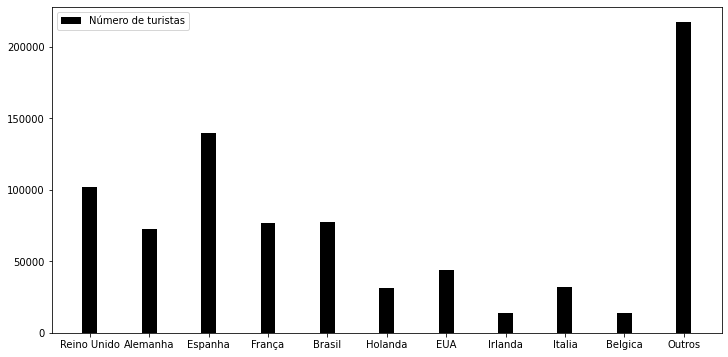

In [14]:
import matplotlib.pyplot as plt

ReinoUnido = dturismo.ReinoUnido.iat[0]
Alemanha = dturismo.Alemanha.iat[0]
Espanha = dturismo.Espanha.iat[0]
França = dturismo.França.iat[0]
Brasil = dturismo.Brasil.iat[0]
Holanda = dturismo.Holanda.iat[0]
EUA = dturismo.EUA.iat[0]
Irlanda = dturismo.Irlanda.iat[0]
Italia = dturismo.Italia.iat[0]
Belgica = dturismo.Belgica.iat[0]
Outros = dturismo.Outros.iat[0]

#parametros do grafico de barras
width = 10
x = [ReinoUnido, Alemanha, Espanha, França, Brasil, Holanda, EUA, Irlanda, Italia, Belgica, Outros]
medida = [0,40,80,120,160,200,240,280,320,360,400]
plt.figure(figsize=(12,6))
plt.bar(medida, x ,width=width, color ='black', label='Número de turistas')
plt.xticks(medida, ['Reino Unido', 'Alemanha', 'Espanha', 'França', 'Brasil', 'Holanda', 'EUA', 'Irlanda', 'Italia', 'Belgica', 'Outros'])

plt.legend(loc="best") #show legend
plt.show()

### Turistas em Portugal por região

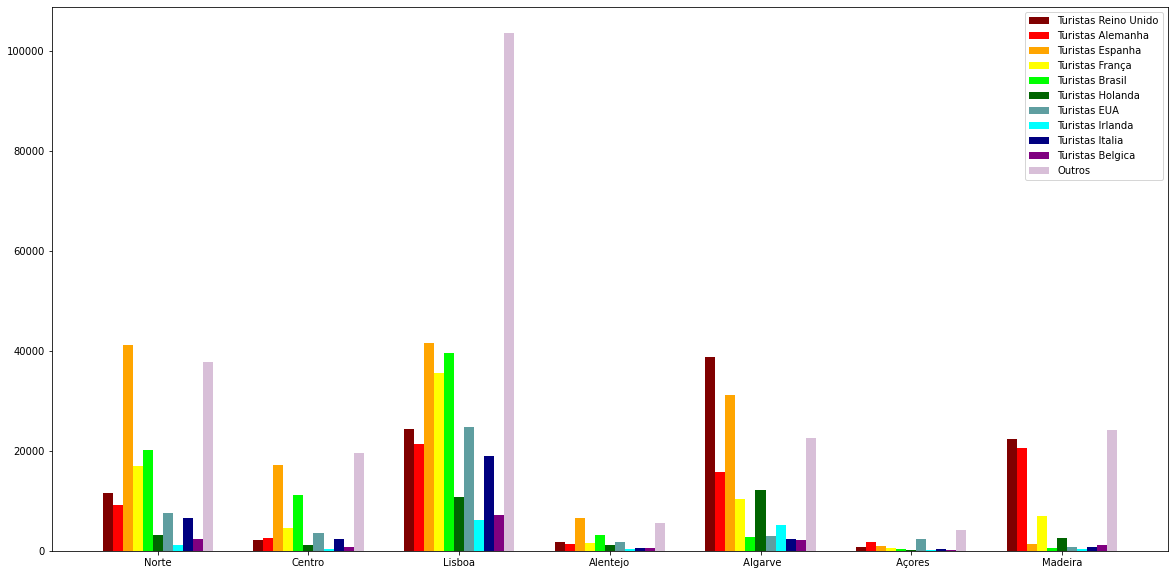

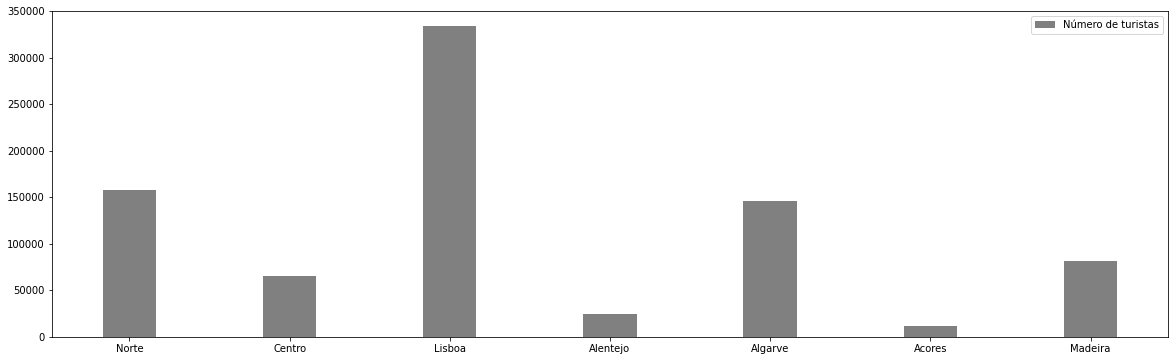

In [15]:
import matplotlib.pyplot as plt
import numpy as np

Norte = []
Centro = []
Lisboa = []
Alentejo = []
Algarve = []
Açores = []
Madeira = []
for i in range(1,12):
   Norte.append(dturismo.loc[1, : ][i])
   Centro.append(dturismo.loc[2, : ][i])
   Lisboa.append(dturismo.loc[3, : ][i])
   Alentejo.append(dturismo.loc[4, : ][i])
   Algarve.append(dturismo.loc[5, : ][i])
   Açores.append(dturismo.loc[6, : ][i])
   Madeira.append(dturismo.loc[7, : ][i])


#parametros do grafico de barras
width = 2
lista = []
for i in range(0,11):
  lista.append([Norte[i], Centro[i], Lisboa[i], Alentejo[i], Algarve[i], Açores[i], Madeira[i]])

plt.figure(figsize=(20,10))

a = [0, 30, 60 ,90, 120,150,180]
ar = np.array(a)

plt.bar(ar, lista[0] ,width=width, color ='maroon', label='Turistas Reino Unido')
plt.bar(ar+width, lista[1] ,width=width, color ='red', label='Turistas Alemanha')
plt.bar(ar+2*width, lista[2] ,width=width, color = 'orange', label='Turistas Espanha')
plt.bar(ar+3*width, lista[3] ,width=width, color = 'yellow', label='Turistas França')
plt.bar(ar+4*width, lista[4] ,width=width, color = 'lime',label='Turistas Brasil')
plt.bar(ar+5*width, lista[5] ,width=width, color = 'darkgreen', label='Turistas Holanda')
plt.bar(ar+6*width, lista[6] ,width=width, color = 'cadetblue', label='Turistas EUA')
plt.bar(ar+7*width, lista[7] ,width=width, color = 'aqua', label='Turistas Irlanda')
plt.bar(ar+8*width, lista[8] ,width=width, color = 'navy', label='Turistas Italia')
plt.bar(ar+9*width, lista[9] ,width=width, color = 'purple', label='Turistas Belgica')
plt.bar(ar+10*width, lista[10] ,width=width, color = 'thistle', label='Outros')

plt.xticks(ar+5*width, ['Norte', 'Centro', 'Lisboa', 'Alentejo', ' Algarve', ' Açores', 'Madeira'])

plt.legend(loc="best") #show legend
plt.show()

import matplotlib.pyplot as plt

Norte = dturismo.Total.iat[1]
Centro = dturismo.Total.iat[2]
Lisboa = dturismo.Total.iat[3]
Alentejo = dturismo.Total.iat[4]
Algarve = dturismo.Total.iat[5]
Acores = dturismo.Total.iat[6]
Madeira = dturismo.Total.iat[7]

#parametros do grafico de barras
width = 5

x = [Norte, Centro, Lisboa, Alentejo, Algarve, Acores, Madeira]
regioes = [0,15,30,45,60,75,90]
plt.figure(figsize=(20,6))
plt.bar( regioes, x, width=width, color ='grey', label='Número de turistas')
plt.xticks(regioes, ['Norte','Centro','Lisboa','Alentejo','Algarve','Acores','Madeira'])

plt.legend(loc="best") #show legend
plt.show()

## COVID-19 em Portugal geográficamente

### Preparação dos dados

In [16]:
#fazer download
import urllib.request

urllib.request.urlretrieve ("https://github.com/jgrocha/covid-pt/raw/master/covid-pt-2020-04-20.gpkg", "covid-pt-2020-04-20.gpkg")

covid_gpkg = "covid-pt-2020-04-20.gpkg"
conn = ogr.Open(covid_gpkg)
for i in conn:
    vlayer = QgsVectorLayer("{}|layername={}".format(covid_gpkg, i.GetName()), i.GetName(), "ogr")
    if not vlayer.isValid():
        print("Layer {} failed to load".format(i.GetName()))
    else:
        QgsProject.instance().addMapLayer(vlayer)
        print("Layer {} loaded".format(i.GetName()))

#for c in concelho.getFeatures():
       # print("Em {} há {} caso(s) confirmados".format(c["concelho"], c["confirmados_concelho_20/04/2020"]))
#expr_sem_casos = QgsExpression( " \"confirmados_concelho_20/04/2020\" IS NULL " )
#virgens = list(concelho.getFeatures( QgsFeatureRequest( expr_sem_casos ) ))
#for c in virgens:
       # print("Em {} não há pelos menos 3 casos confirmados".format(c["concelho"]))

Layer concelho loaded
Layer distrito loaded
Layer raa_central_concelho loaded
Layer raa_central_ilha loaded
Layer raa_ocidental_concelho loaded
Layer raa_ocidental_ilha loaded
Layer raa_oriental_concelho loaded
Layer raa_oriental_ilha loaded
Layer ram_concelho loaded
Layer ram_ilha loaded
Layer layer_styles loaded
Layer confirmados_concelho loaded
Layer confirmados_distrito_ilha loaded
Layer situacao_epidemiologica loaded


In [0]:
def gereMapa(layer):
    xt = layer.extent()
    width  = 400
    height = int(width*xt.height()/xt.width())
   

    options = QgsMapSettings()
    options.setLayers([layer])
    options.setBackgroundColor(QColor(255, 255, 255))
    options.setOutputSize(QSize(width, height))
    options.setExtent(xt)
              
    render = QgsMapRendererParallelJob(options)
    render.start()
    render.waitForFinished()

    image = render.renderedImage()
    return image


### **Mapa de Portugal por Distrito**

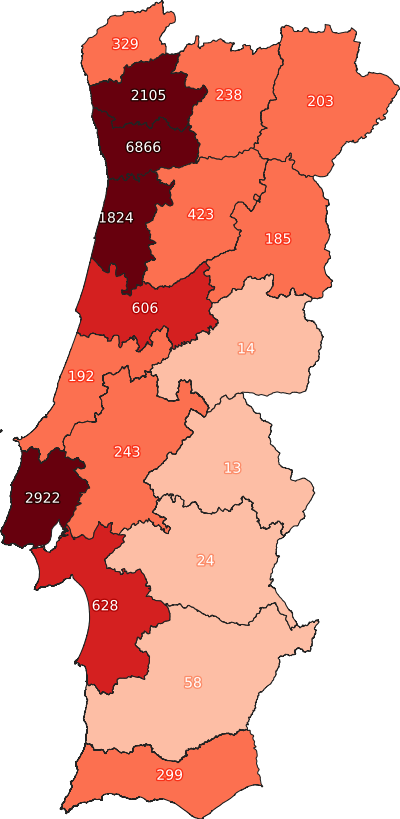

In [18]:
from IPython.display import Image
distrito = QgsProject.instance().mapLayersByName('distrito')[0]
image = gereMapa (distrito)

imgbuf= QBuffer()
imgbuf.open( QIODevice.ReadWrite )
image.save( imgbuf,"PNG" )
Image( imgbuf.data() )


### **Mapa de Portugal por Conselho**

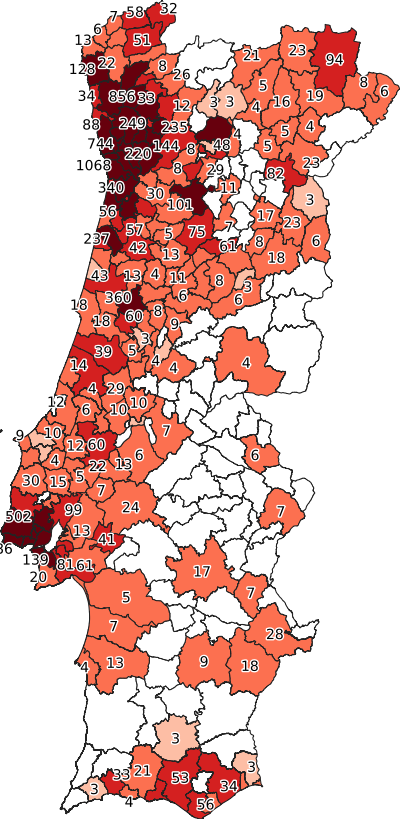

In [19]:
from IPython.display import Image
concelho = QgsProject.instance().mapLayersByName('concelho')[0]
image = gereMapa(concelho)

imgbuf= QBuffer()
imgbuf.open( QIODevice.ReadWrite )
image.save( imgbuf,"PNG" )
Image( imgbuf.data() )

## Análise dos dados do COVID-19 em Portugal

Neste tópico, houve a elaboração de alguns gráficos acerca de vários assuntos relacionados com o COVID em Portugal. 

Fez-se gráficos acerca da evolução dos casos confirmados, óbitos e recuperados em Portugal e gráficos que mostram a quantidade de pessoas internadas no hospital ou mesmo nos cuidados intensidos ao longo destes 2 meses. Também se criou tanto um gráfico onde mostra os casos confirmados consoante a idade e género, tanto um que verifica a quantidade de mortes por idade, ou seja, em que idades há uma maior probabilidade de se não resistir à doença. 

Por fim, fez-se um gráfico que indica quais os sintomas mais apresentados nas pessoas com a doença confirmada. 

In [0]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/jgrocha/covid-pt/master/situacao_epidemiologica.csv")



### Evolução do número de casos confirmados de COVID-19 em Portugal

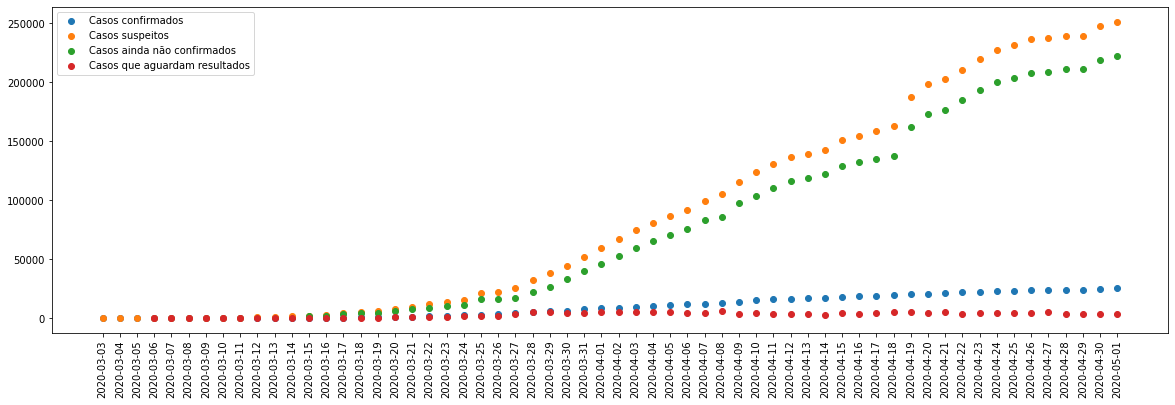

In [34]:
import matplotlib.pyplot as plt

sorted_df = df.sort_values(by=['data_relatorio'])

x = sorted_df.data_relatorio
y = sorted_df.confirmados
z = sorted_df.suspeitos
d = sorted_df.nao_confirmados
e = sorted_df.aguarda_resultados

plt.figure(figsize=(20,6))
plt.scatter(x, y, label= "Casos confirmados")
plt.scatter(x, z, label = "Casos suspeitos")
plt.scatter(x, d, label = "Casos ainda não confirmados")
plt.scatter(x, e, label= "Casos que aguardam resultados")
plt.xticks(rotation=90)
plt.legend(loc="best") #show legend
plt.show()

### Casos confirmados, recuperados e obitos em Portugal

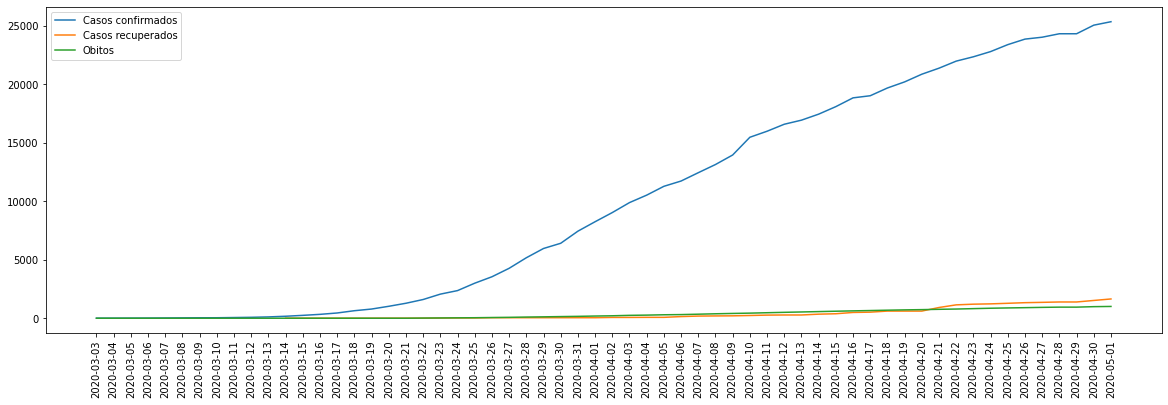

Portugal está atualmente com uma taxa de mortabilidade e taxa de recuperação de...


In [33]:
import matplotlib.pyplot as plt

sorted_df = df.sort_values(by=['data_relatorio'])

x = sorted_df.data_relatorio
y = sorted_df.confirmados
z = sorted_df.recuperados
m = sorted_df.obitos

plt.figure(figsize=(20,6))
plt.plot(x, y, label="Casos confirmados")
plt.plot(x, z, label="Casos recuperados")
plt.plot(x, m, label="Obitos")
plt.xticks(rotation=90)
plt.legend(loc="best") #show legend
plt.show()

print ('Portugal está atualmente com uma taxa de mortabilidade e taxa de recuperação de...')

### Quantidade de pessoas nos hospitais portugueses

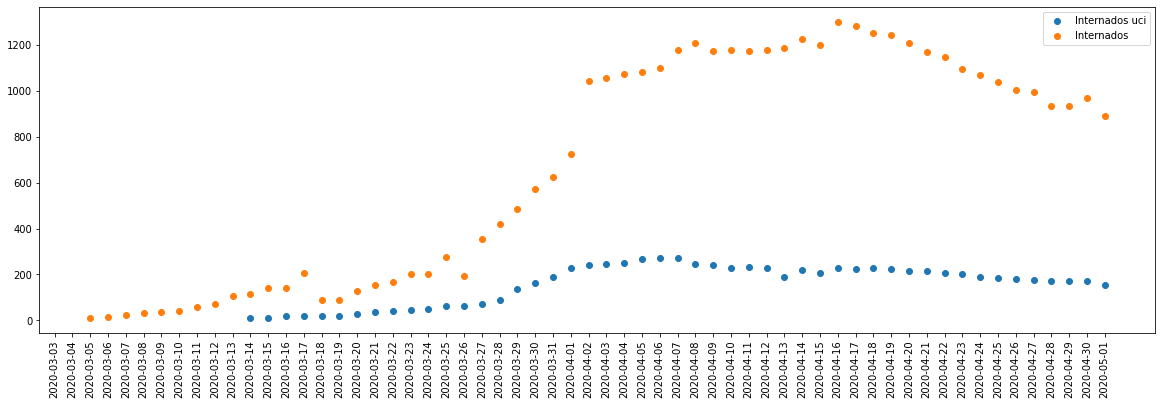

In [32]:
import matplotlib.pyplot as plt

sorted_df = df.sort_values(by=['data_relatorio'])

x = sorted_df.data_relatorio
y = sorted_df.internados_uci
z = sorted_df.internados


plt.figure(figsize=(20,6))
plt.scatter(x, y, label= "Internados uci")
plt.scatter(x, z, label= "Internados")
plt.xticks(rotation=90)

#plt.xticks([50], ['datas'])

plt.legend(loc="best") #show legend
plt.show()

### Número de casos confirmados até à última data por idade 

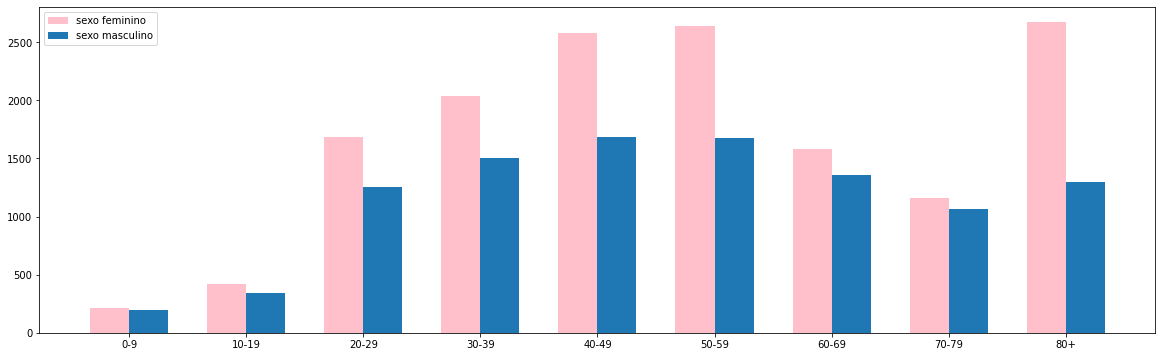

In [24]:
import matplotlib.pyplot as plt
import numpy as np

sorted_df = df.sort_values(by=['data_relatorio'])

a = sorted_df.confirmados_feminino_0_9.iat[-1]
b = sorted_df.confirmados_feminino_10_19.iat[-1]
c = sorted_df.confirmados_feminino_20_29.iat[-1]
d = sorted_df.confirmados_feminino_30_39.iat[-1]
e = sorted_df.confirmados_feminino_40_49.iat[-1]
f = sorted_df.confirmados_feminino_50_59.iat[-1]
g = sorted_df.confirmados_feminino_60_69.iat[-1]
h = sorted_df.confirmados_feminino_70_79.iat[-1]
i = sorted_df.confirmados_feminino_80_sup.iat[-1]

aa = sorted_df.confirmados_masculino_0_9.iat[-1]
bb = sorted_df.confirmados_masculino_10_19.iat[-1]
cc = sorted_df.confirmados_masculino_20_29.iat[-1]
dd = sorted_df.confirmados_masculino_30_39.iat[-1]
ee = sorted_df.confirmados_masculino_40_49.iat[-1]
ff = sorted_df.confirmados_masculino_50_59.iat[-1]
gg = sorted_df.confirmados_masculino_60_69.iat[-1]
hh = sorted_df.confirmados_masculino_70_79.iat[-1]
ii = sorted_df.confirmados_masculino_80_sup.iat[-1]

#parametros do grafico de barras
width = 5


x = [a,b,c,d,e,f,g,h,i]
y = [aa,bb,cc,dd,ee,ff,gg,hh,ii]


mulheres = [0,15,30,45,60,75,90,105,120]

homens = [5,20,35,50,65,80,95,110,125]

meio = [2.5,17.5,32.5,47.5,62.5,77.5,92.5,107.5,122.5]
plt.figure(figsize=(20,6))
plt.bar(mulheres, x, width=width, color ='pink', label='sexo feminino')
plt.bar(homens, y, width=width, label='sexo masculino')

plt.xticks(meio, ['0-9','10-19','20-29','30-39','40-49','50-59','60-69','70-79','80+'])

plt.legend(loc="best") #show legend
plt.show()
 



### Número de óbitos até à última data por idade 

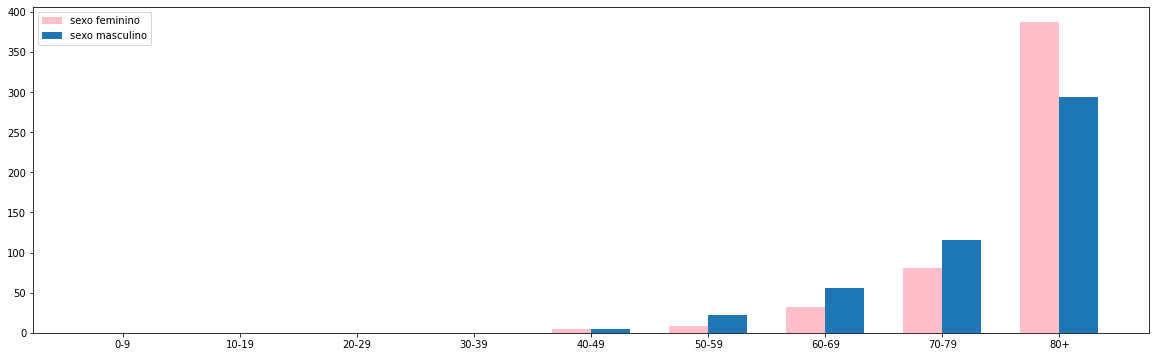

In [25]:
import matplotlib.pyplot as plt
import numpy as np

sorted_df = df.sort_values(by=['data_relatorio'])

a = sorted_df.obitos_feminino_0_9.iat[-1]
b = sorted_df.obitos_feminino_10_19.iat[-1]
c = sorted_df.obitos_feminino_20_29.iat[-1]
d = sorted_df.obitos_feminino_30_39.iat[-1]
e = sorted_df.obitos_feminino_40_49.iat[-1]
f = sorted_df.obitos_feminino_50_59.iat[-1]
g = sorted_df.obitos_feminino_60_69.iat[-1]
h = sorted_df.obitos_feminino_70_79.iat[-1]
i = sorted_df.obitos_feminino_80_sup.iat[-1]

aa = sorted_df.obitos_masculino_0_9.iat[-1]
bb = sorted_df.obitos_masculino_10_19.iat[-1]
cc = sorted_df.obitos_masculino_20_29.iat[-1]
dd = sorted_df.obitos_masculino_30_39.iat[-1]
ee = sorted_df.obitos_masculino_40_49.iat[-1]
ff = sorted_df.obitos_masculino_50_59.iat[-1]
gg = sorted_df.obitos_masculino_60_69.iat[-1]
hh = sorted_df.obitos_masculino_70_79.iat[-1]
ii = sorted_df.obitos_masculino_80_sup.iat[-1]

#parametros do grafico de barras
width = 5


x = [a,b,c,d,e,f,g,h,i]
y = [aa,bb,cc,dd,ee,ff,gg,hh,ii]


mulheres = [0,15,30,45,60,75,90,105,120]

homens = [5,20,35,50,65,80,95,110,125]

meio = [2.5,17.5,32.5,47.5,62.5,77.5,92.5,107.5,122.5]
plt.figure(figsize=(20,6))
plt.bar(mulheres, x, width=width, color ='pink', label='sexo feminino')
plt.bar(homens, y, width=width, label='sexo masculino')

plt.xticks(meio, ['0-9','10-19','20-29','30-39','40-49','50-59','60-69','70-79','80+'])

plt.legend(loc="best") #show legend
plt.show()
 


### Sintomas do COVID-19 nos casos confirmados

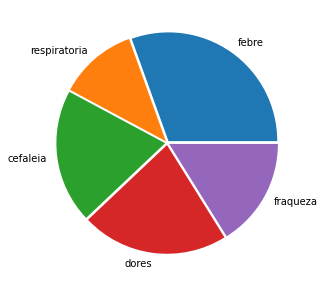

In [26]:
import matplotlib.pyplot as plt

f = df.sintoma_febre.mean()
r = df.sintoma_respiratoria.mean()
c = df.sintoma_cefaleia.mean()
d = df.sintoma_dores.mean()
fr = df.sintoma_fraqueza.mean()

x = [f, r, c, d, fr]

dataName = ['febre', 'respiratoria', 'cefaleia', 'dores', 'fraqueza']
explode = [0.02, 0.02, 0.02, 0.02, 0.02] 

plt.figure(figsize=(5,5))

plt.pie(x, explode=explode, labels = dataName) 
plt.show()

### Proporção de pessoas infetadas com a população 

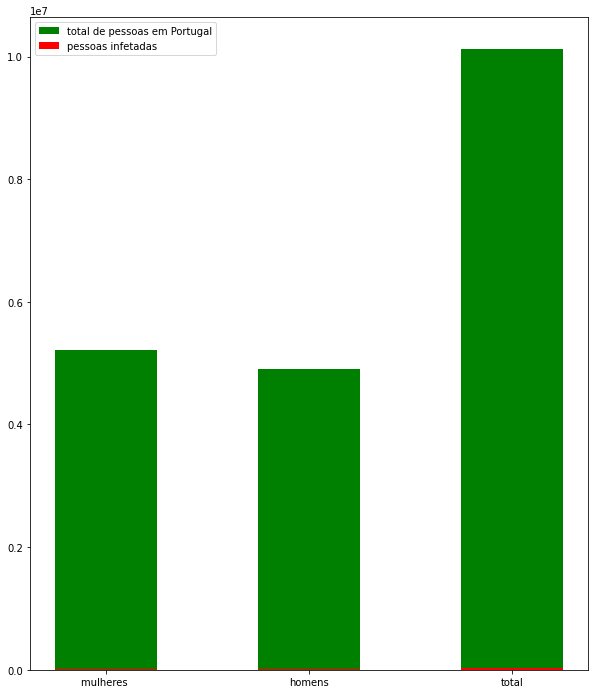

Há 14983.0 mulheres infetadas, 10368.0 homens infetados. Isto dá um total de 25351.0 pessoas infetadas em Portugal.


In [27]:
import matplotlib.pyplot as plt
import numpy as np

sorted_df = df.sort_values(by=['data_relatorio'])

a = sorted_df.confirmados_feminino_0_9.iat[-1]
b = sorted_df.confirmados_feminino_10_19.iat[-1]
c = sorted_df.confirmados_feminino_20_29.iat[-1]
d = sorted_df.confirmados_feminino_30_39.iat[-1]
e = sorted_df.confirmados_feminino_40_49.iat[-1]
f = sorted_df.confirmados_feminino_50_59.iat[-1]
g = sorted_df.confirmados_feminino_60_69.iat[-1]
h = sorted_df.confirmados_feminino_70_79.iat[-1]
i = sorted_df.confirmados_feminino_80_sup.iat[-1]

mulheresInfetadas = a+b+c+d+e+f+g+h+i

aa = sorted_df.confirmados_masculino_0_9.iat[-1]
bb = sorted_df.confirmados_masculino_10_19.iat[-1]
cc = sorted_df.confirmados_masculino_20_29.iat[-1]
dd = sorted_df.confirmados_masculino_30_39.iat[-1]
ee = sorted_df.confirmados_masculino_40_49.iat[-1]
ff = sorted_df.confirmados_masculino_50_59.iat[-1]
gg = sorted_df.confirmados_masculino_60_69.iat[-1]
hh = sorted_df.confirmados_masculino_70_79.iat[-1]
ii = sorted_df.confirmados_masculino_80_sup.iat[-1]

homensInfetados = aa+bb+cc+dd+ee+ff+gg+hh+ii 

#descobrir a proporção de mulheres infetadas e homens infetados
total = 10130284
mulheres = 5221823
homens = 4908461

totalInfetado = homensInfetados + mulheresInfetadas

#parametros do grafico de barras
width = 5

x = [mulheresInfetadas, homensInfetados, totalInfetado]
y = [mulheres, homens, total]

infetados = [0,10,20]

saudavel = [0,10,20]

plt.figure(figsize=(10,12))
plt.bar(saudavel, y, width=width, color = 'green', label='total de pessoas em Portugal')
plt.bar(infetados, x, width=width, color ='red', bottom=saudavel, label='pessoas infetadas')

plt.xticks(infetados, ['mulheres ', 'homens', 'total'])


plt.legend(loc="best") #show legend
plt.show()


print("Há " + str(mulheresInfetadas) + " mulheres infetadas, "+ str(homensInfetados)+ " homens infetados. Isto dá um total de "+ str(totalInfetado) + " pessoas infetadas em Portugal.")



## Conclusão